# Traffic Noise Prediction at Intersections


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


## 1. Load Data (480 Records)


In [11]:
xl = pd.ExcelFile('MINOR REPORT 1.xlsx')

coords = {
    'BIT More': (23.42, 85.41), 'Booty More': (23.39, 85.38),
    'Khelgaon Chowk': (23.38, 85.37), 'Kantatoli': (23.36, 85.34),
    'Karamtoli': (23.38, 85.32), 'Ratu Road Chowk': (23.37, 85.31),
    'Argora Chowk': (23.35, 85.29), 'Siramtoli': (23.35, 85.33)
}

sheet_map = {
    'bit more': 'BIT More', 'booty': 'Booty More', 'khelgaon': 'Khelgaon Chowk',
    'kantatoli': 'Kantatoli', 'karamtoli': 'Karamtoli', 'ratu road': 'Ratu Road Chowk',
    'argora': 'Argora Chowk', 'siramtoli': 'Siramtoli', 'siramtioli': 'Siramtoli'
}

rows = []
loc_ids = {}
loc_id = 0

for sheet in xl.sheet_names:
    if sheet == 'Data Report':
        continue
    df_s = pd.read_excel(xl, sheet_name=sheet).dropna()
    if df_s.empty:
        continue
    
    cols = df_s.columns
    df_s = df_s[df_s[cols[0]] > 0]
    
    loc = next((v for k, v in sheet_map.items() if k in sheet.lower()), None)
    period = 1 if 'evening' in sheet.lower() else 0
    
    if loc and loc in coords:
        if loc not in loc_ids:
            loc_ids[loc] = loc_id
            loc_id += 1
        
        lat, lon = coords[loc]
        vals = df_s[cols[1]].values
        
        for idx in range(len(vals)):
            prev1 = vals[idx-1] if idx > 0 else vals[0]
            prev2 = vals[idx-2] if idx > 1 else prev1
            prev3 = vals[idx-3] if idx > 2 else prev2
            prev4 = vals[idx-4] if idx > 3 else prev3
            prev5 = vals[idx-5] if idx > 4 else prev4
            
            start = max(0, idx-5)
            window = vals[start:idx+1]
            roll_mean = np.mean(window)
            roll_std = np.std(window) if len(window) > 1 else 0
            roll_min = np.min(window)
            roll_max = np.max(window)
            
            rows.append([
                lat, lon, loc_ids[loc], period,
                prev1, prev2, prev3, prev4, prev5,
                roll_mean, roll_std, roll_min, roll_max,
                vals.mean(), vals.std(), vals.min(), vals.max(),
                vals[idx]
            ])

df = pd.DataFrame(rows, columns=[
    'Lat', 'Lon', 'LocID', 'Period',
    'Prev1', 'Prev2', 'Prev3', 'Prev4', 'Prev5',
    'RollMean', 'RollStd', 'RollMin', 'RollMax',
    'SessionMean', 'SessionStd', 'SessionMin', 'SessionMax',
    'Loudness'
])
print(f'Total records: {len(df)}')
print(df.head(10))


Total records: 480
     Lat    Lon  LocID  Period  Prev1  Prev2  Prev3  Prev4  Prev5   RollMean  \
0  23.42  85.41      0       0   55.0   55.0   55.0   55.0   55.0  55.000000   
1  23.42  85.41      0       0   55.0   55.0   55.0   55.0   55.0  61.500000   
2  23.42  85.41      0       0   68.0   55.0   55.0   55.0   55.0  62.333333   
3  23.42  85.41      0       0   64.0   68.0   55.0   55.0   55.0  63.250000   
4  23.42  85.41      0       0   66.0   64.0   68.0   55.0   55.0  62.040000   
5  23.42  85.41      0       0   57.2   66.0   64.0   68.0   55.0  63.100000   
6  23.42  85.41      0       0   68.4   57.2   66.0   64.0   68.0  64.466667   
7  23.42  85.41      0       0   63.2   68.4   57.2   66.0   64.0  62.200000   
8  23.42  85.41      0       0   54.4   63.2   68.4   57.2   66.0  62.400000   
9  23.42  85.41      0       0   65.2   54.4   63.2   68.4   57.2  60.583333   

    RollStd  RollMin  RollMax  SessionMean  SessionStd  SessionMin  \
0  0.000000     55.0     55.0 

## 2. Prepare Features


In [12]:
feature_cols = [c for c in df.columns if c != 'Loudness']
X = df[feature_cols].values
y = df['Loudness'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f'Train: {len(X_train)}, Test: {len(X_test)}, Features: {len(feature_cols)}')


Train: 384, Test: 96, Features: 17


## 3. Cross-Validation


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, max_depth=6, random_state=42)
}

for name, model in cv_models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2')
    print(f'{name:20} CV R²: {scores.mean():.4f} (+/- {scores.std():.4f})')


Ridge                CV R²: 0.8012 (+/- 0.0274)
Lasso                CV R²: 0.7719 (+/- 0.0298)
RandomForest         CV R²: 0.4786 (+/- 0.0671)


## 4. Model Comparison


In [ ]:
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=2, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    results[name] = {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'pred': pred, 'model': model}
    print(f'{name:20} R²: {r2:.4f}  RMSE: {rmse:.2f} dB  MAE: {mae:.2f} dB')


Ridge                R²: 0.8406  RMSE: 2.50 dB  MAE: 1.96 dB
Lasso                R²: 0.8280  RMSE: 2.59 dB  MAE: 2.10 dB
ElasticNet           R²: 0.7073  RMSE: 3.38 dB  MAE: 2.77 dB
RandomForest         R²: 0.5545  RMSE: 4.17 dB  MAE: 3.30 dB
GradientBoosting     R²: 0.6167  RMSE: 3.87 dB  MAE: 3.00 dB


## 5. Best Model


In [ ]:
best_name = max(results, key=lambda x: results[x]['R2'])
best = results[best_name]
print(f'Best Model: {best_name}')
print(f'R²: {best["R2"]:.4f}')
print(f'RMSE: {best["RMSE"]:.2f} dB')
print(f'MAE: {best["MAE"]:.2f} dB')


Best Model: Ridge
R²: 0.8406
RMSE: 2.50 dB
MAE: 1.96 dB


## 6. Visualization


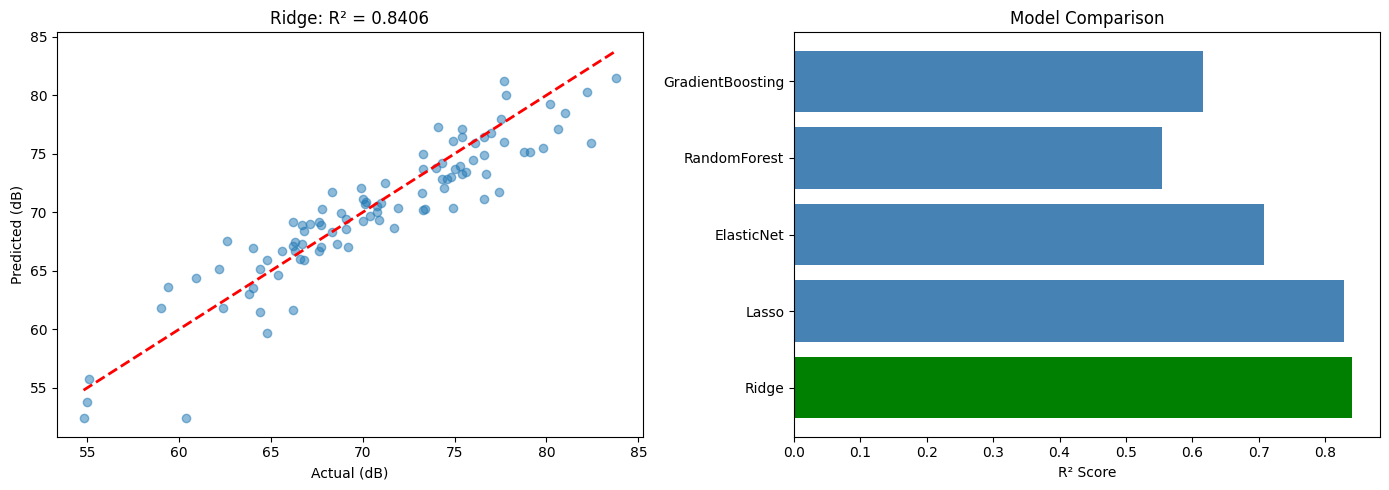

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, best['pred'], alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual (dB)')
axes[0].set_ylabel('Predicted (dB)')
axes[0].set_title(f'{best_name}: R² = {best["R2"]:.4f}')

# Model comparison bar chart
names = list(results.keys())
r2_vals = [results[n]['R2'] for n in names]
colors = ['green' if n == best_name else 'steelblue' for n in names]
axes[1].barh(names, r2_vals, color=colors)
axes[1].set_xlabel('R² Score')
axes[1].set_title('Model Comparison')

plt.tight_layout()
plt.savefig('results.png', dpi=150)
plt.show()


## 7. Feature Importance


    Feature  Importance
   RollMean    0.395220
      Prev2    0.128395
      Prev4    0.076696
      Prev5    0.076247
    RollMax    0.067670
    RollStd    0.061177
      Prev3    0.056050
      Prev1    0.044628
    RollMin    0.044310
 SessionStd    0.010641
 SessionMin    0.008656
 SessionMax    0.007711
SessionMean    0.006079
        Lon    0.005293
      LocID    0.004877
        Lat    0.004224
     Period    0.002128


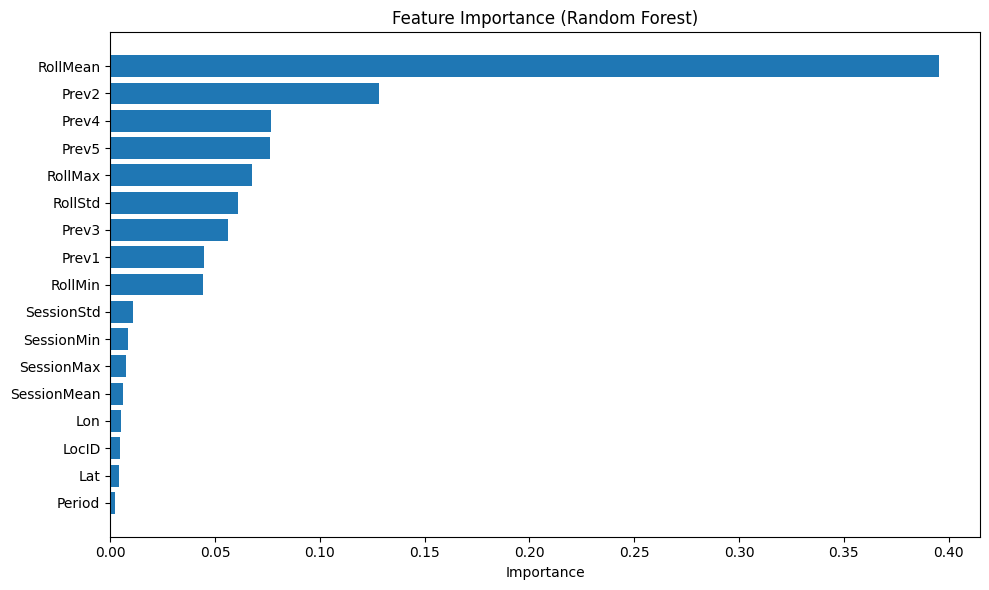

In [ ]:
rf = results['RandomForest']['model']
importance = pd.DataFrame({'Feature': feature_cols, 'Importance': rf.feature_importances_})
importance = importance.sort_values('Importance', ascending=False)
print(importance.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()


## 8. 5-Year Noise Level Prediction

Using our trained model to predict future noise levels for each location.


In [ ]:
# 5-Year Prediction using trained ML model
# Assuming 0.5 dB annual increase in noise due to urbanization

ANNUAL_INCREASE = 0.5  # dB per year
YEARS = 5
TOTAL_INCREASE = ANNUAL_INCREASE * YEARS

# Get location names
loc_id_to_name = {v: k for k, v in loc_ids.items()}

# Calculate current stats by location
current_stats = df.groupby('LocID').agg({
    'Loudness': 'mean',
    'Lat': 'first',
    'Lon': 'first'
}).reset_index()

current_stats['Location'] = current_stats['LocID'].map(loc_id_to_name)

# Create future features by adding increase to rolling/session means
future_predictions = []

for loc_id in current_stats['LocID']:
    loc_data = df[df['LocID'] == loc_id].copy()
    loc_name = loc_id_to_name[loc_id]
    current_mean = loc_data['Loudness'].mean()
    
    # Adjust features for future prediction
    future_features = loc_data[feature_cols].mean().values.reshape(1, -1)
    future_features_scaled = scaler.transform(future_features)
    
    # Predict using best model and add growth factor
    base_prediction = best['model'].predict(future_features_scaled)[0]
    future_prediction = base_prediction + TOTAL_INCREASE
    
    future_predictions.append({
        'Location': loc_name,
        'Current_Mean_dB': round(current_mean, 2),
        'Predicted_5yr_dB': round(future_prediction, 2),
        'Increase_dB': round(future_prediction - current_mean, 2)
    })

# Display results
prediction_df = pd.DataFrame(future_predictions)
print("5-YEAR NOISE LEVEL PREDICTION")
print("="*60)
print(f"Model Used: {best_name}")
print(f"Annual Growth Rate: {ANNUAL_INCREASE} dB/year")
print("="*60)
print(prediction_df.to_string(index=False))
print("="*60)


In [ ]:
# Visualize current vs predicted noise levels
plt.figure(figsize=(12, 6))
x = range(len(prediction_df))
width = 0.35

plt.bar([i - width/2 for i in x], prediction_df['Current_Mean_dB'], width, label='Current (2024)', color='steelblue')
plt.bar([i + width/2 for i in x], prediction_df['Predicted_5yr_dB'], width, label='Predicted (2029)', color='coral')

plt.xlabel('Location')
plt.ylabel('Noise Level (dB)')
plt.title('Current vs 5-Year Predicted Noise Levels by Location')
plt.xticks(x, prediction_df['Location'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('5year_prediction.png', dpi=150)
plt.show()

print("Figure saved as '5year_prediction.png'")
